# Project Title: Traffic Forecasting App for Urban Cities

**Team Member**

Babita Kurmi (bkkurmi@iu.edu) 


This project aims to predict traffic conditions in urban areas using time series forecasting methods. The goal is to create a more accurate traffic prediction tool by incorporating data such as weather, time of day, holidays, and other influencing factors. This tool will be valuable to commuters, city planners, and delivery services, helping them plan routes more effectively and avoid congested areas.

## Dataset

For this project, I will use the Metro Interstate Traffic Volume dataset, available on Kaggle. The dataset contains hourly traffic data for westbound I-94, a major highway connecting Minneapolis and St. Paul, Minnesota. The dataset includes important features such as weather conditions, traffic volume, temperature, and holiday information, which will help in predicting traffic patterns.

**Dataset Details**

Source - The dataset was collected by the Minnesota Department of Transportation (MnDOT) between 2012 and 2018 at a station on I-94, located roughly halfway between Minneapolis and St. Paul. 
The purpose of data collection was to monitor traffic patterns and assist in transportation planning.

Kaggle data owner - John Hogue

Link to dataset on Kaggle - https://www.kaggle.com/datasets/anshtanwar/metro-interstate-traffic-volume/data 


In [1]:
pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

### Read dataset

In [3]:
# Load the dataset
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
print("First few rows:")
df.head()

First few rows:


,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,5545,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,02-10-2012 09:00
1,4516,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,02-10-2012 10:00
2,4767,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 11:00
3,5026,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,02-10-2012 12:00
4,4918,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,02-10-2012 13:00


### Display basic information about the dataset


In [4]:
# Display basic information about the dataset
print("Dataset shape:", df.shape)


Dataset shape: (48204, 9)


Checking Duplicates

In [5]:
df[df.duplicated()]

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
18697,3679,NaN,286.290,0.0,0.0,1,Clear,sky is clear,30-09-2015 19:00
23851,4831,NaN,289.060,0.0,0.0,90,Clouds,overcast clouds,01-06-2016 10:00
26784,5365,NaN,289.775,0.0,0.0,56,Clouds,broken clouds,21-09-2016 15:00
26980,3435,NaN,287.860,0.0,0.0,0,Clear,Sky is Clear,29-09-2016 19:00
27171,4642,NaN,279.287,0.0,0.0,56,Clouds,broken clouds,07-10-2016 18:00
28879,4520,NaN,267.890,0.0,0.0,90,Snow,light snow,06-12-2016 18:00
29268,420,NaN,254.220,0.0,0.0,1,Clear,sky is clear,19-12-2016 00:00
34711,4808,NaN,295.010,0.0,0.0,40,Clouds,scattered clouds,21-06-2017 11:00
34967,4638,NaN,292.840,0.0,0.0,1,Clear,sky is clear,30-06-2017 10:00
34969,4725,NaN,294.520,0.0,0.0,1,Clear,sky is clear,30-06-2017 11:00


Drop duplicates rows

In [6]:
df = df.drop_duplicates(subset=None, keep='first', inplace=False)

Check duplicate after dropping

In [7]:
df[df.duplicated()]

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time


All duplicates are dropped.

In [8]:
# checking shape again after droping duplicate
df.shape

(48187, 9)

In [9]:
print("Dataset info:")
df.info()

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 48187 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48187 non-null  int64  
 1   holiday              61 non-null     object 
 2   temp                 48187 non-null  float64
 3   rain_1h              48187 non-null  float64
 4   snow_1h              48187 non-null  float64
 5   clouds_all           48187 non-null  int64  
 6   weather_main         48187 non-null  object 
 7   weather_description  48187 non-null  object 
 8   date_time            48187 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 3.7+ MB


In [10]:
print("Summary statistics:")
df.describe(include='all')

Summary statistics:


,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
count,48187.000000,61,48187.000000,48187.000000,48187.000000,48187.000000,48187,48187,48187
unique,NaN,11,NaN,NaN,NaN,NaN,11,38,40575
top,NaN,Labor Day,NaN,NaN,NaN,NaN,Clouds,sky is clear,18-04-2013 22:00
freq,NaN,7,NaN,NaN,NaN,NaN,15158,11659,6
mean,3259.618134,NaN,281.204995,0.334382,0.000222,49.365451,NaN,NaN,NaN
std,1986.954465,NaN,13.338738,44.797033,0.008169,39.015213,NaN,NaN,NaN
min,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,1192.500000,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,NaN
50%,3379.000000,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,NaN
75%,4933.000000,NaN,291.806000,0.000000,0.000000,90.000000,NaN,NaN,NaN


Convert date_time to datetime

In [11]:
# Convert date_time to datetime
df['date_time'] = pd.to_datetime(df['date_time'], format="%d-%m-%Y %H:%M")
df = df.set_index('date_time')

Check for missing values

In [12]:
df.isnull().sum()

traffic_volume             0
holiday                48126
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
dtype: int64

**Note:** the holiday column has large missing values, which is expected.

Fill holiday with 'Workday' if missing, else leave as it is


In [13]:
# Fill holiday with 'Workday' if missing, else leave as it is
df['holiday'] = df['holiday'].fillna('Workday')


In [15]:
df.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,,
2012-10-02 09:00:00,5545,Workday,288.28,0.0,0.0,40,Clouds,scattered clouds
2012-10-02 10:00:00,4516,Workday,289.36,0.0,0.0,75,Clouds,broken clouds
2012-10-02 11:00:00,4767,Workday,289.58,0.0,0.0,90,Clouds,overcast clouds
2012-10-02 12:00:00,5026,Workday,290.13,0.0,0.0,90,Clouds,overcast clouds
2012-10-02 13:00:00,4918,Workday,291.14,0.0,0.0,75,Clouds,broken clouds


count to see how many data per year

In [16]:
# Group by year and count rows
yearly_counts = df.resample('Y').size()
print(yearly_counts)

date_time
2012-12-31     2559
2013-12-31     8573
2014-12-31     4839
2015-12-31     4372
2016-12-31     9300
2017-12-31    10596
2018-12-31     7948
Freq: A-DEC, dtype: int64


Convert temperature from Kelvin to Fehrenheit for better interpretability

In [17]:
# Convert temperature from Kelvin to Celsius 
#df['temp_celsius'] = df['temp'] - 273.15

# Convert from Kelvin to Fahrenheit
df['temp_fahrenheit'] = (df['temp'] - 273.15) * 9/5 + 32

In [18]:
df['temp_fahrenheit'].head()

date_time
2012-10-02 09:00:00    59.234
2012-10-02 10:00:00    61.178
2012-10-02 11:00:00    61.574
2012-10-02 12:00:00    62.564
2012-10-02 13:00:00    64.382
Name: temp_fahrenheit, dtype: float64

Create time-based features

In [19]:
# Create additional time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month
df['year'] = df.index.year
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

Python's pandas library, the day of the week is indexed as follows

0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday, 6: Sunday

Creating a binary indicator for whether a specific day is a holiday or not

In [24]:
# Create a binary holiday indicator
#df['is_holiday'] = (~df['holiday'].isna()).astype(int)

df['is_holiday'] = np.where(df['holiday'] == 'Workday', 0, 1)


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48187 entries, 2012-10-02 09:00:00 to 2018-09-30 23:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       48187 non-null  int64  
 1   holiday              48187 non-null  object 
 2   temp                 48187 non-null  float64
 3   rain_1h              48187 non-null  float64
 4   snow_1h              48187 non-null  float64
 5   clouds_all           48187 non-null  int64  
 6   weather_main         48187 non-null  object 
 7   weather_description  48187 non-null  object 
 8   temp_fahrenheit      48187 non-null  float64
 9   hour                 48187 non-null  int32  
 10  day_of_week          48187 non-null  int32  
 11  month                48187 non-null  int32  
 12  year                 48187 non-null  int32  
 13  is_weekend           48187 non-null  int32  
 14  is_holiday           48187 non-null  int32  
dtypes

In [26]:
df.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,temp_fahrenheit,hour,day_of_week,month,year,is_weekend,is_holiday
date_time,,,,,,,,,,,,,,,
2012-10-02 09:00:00,5545,Workday,288.28,0.0,0.0,40,Clouds,scattered clouds,59.234,9,1,10,2012,0,0
2012-10-02 10:00:00,4516,Workday,289.36,0.0,0.0,75,Clouds,broken clouds,61.178,10,1,10,2012,0,0
2012-10-02 11:00:00,4767,Workday,289.58,0.0,0.0,90,Clouds,overcast clouds,61.574,11,1,10,2012,0,0
2012-10-02 12:00:00,5026,Workday,290.13,0.0,0.0,90,Clouds,overcast clouds,62.564,12,1,10,2012,0,0
2012-10-02 13:00:00,4918,Workday,291.14,0.0,0.0,75,Clouds,broken clouds,64.382,13,1,10,2012,0,0


In column is_weekend, 0 = weekdays and 1 = Weekend (i.e. Saturday and Sunday)

In column, is_holiday , 0 = Workday and 1 =  Holiday

In [27]:
df.holiday.value_counts()

holiday
Workday                      48126
Labor Day                        7
Thanksgiving Day                 6
Christmas Day                    6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Washingtons Birthday             5
Memorial Day                     5
Independence Day                 5
State Fair                       5
Name: count, dtype: int64

### 1. Time series decomposition 

Resampling traffic volume data to a daily frequency. This will simplify the data, making it easier to analyze trends, seasonality, and residuals through time series decomposition. By aggregating the data to a daily level, we reduce noise and are better able to detect long-term patterns and seasonal effects.

In [28]:
# Resample to daily data for decomposition
daily_data = df['traffic_volume'].resample('D').mean()

In [29]:
# Fill any missing values that might have been created during resampling
daily_data = daily_data.fillna(daily_data.bfill())

In [30]:
# Perform time series decomposition
# 7 days for weekly seasonality
decomposition = seasonal_decompose(daily_data, model='additive', period=7)  


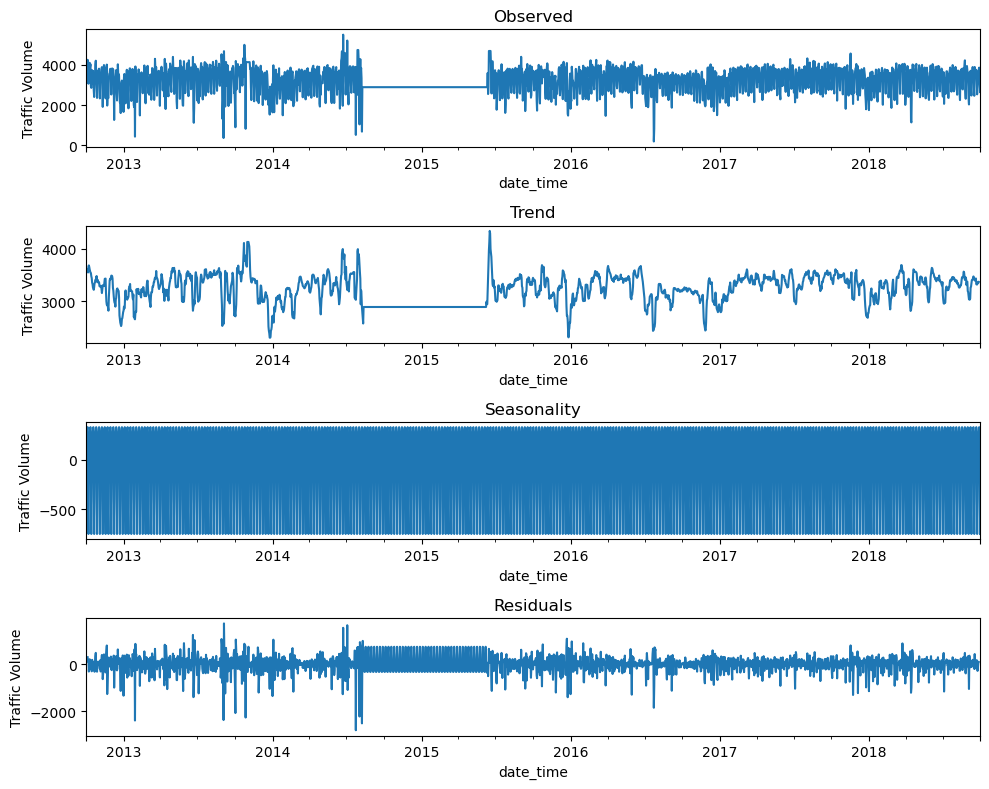

In [31]:
# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
ax1.set_ylabel('Traffic Volume')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Traffic Volume')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Traffic Volume')

decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()

Trend- The plot shows a general pattern of varying traffic volume over time, with some periods of higher and lower activity. From 2016 onward, the trend seems relatively stable compared to 2013-2015.

Seasonality- The plot shows a repeating pattern, indicating a cyclical variation in traffic volume. This suggests that traffic volume has regular and predictable fluctuations.

Also perform decomposition on hourly data for a shorter period to see daily patterns

In [32]:
# Select a month of data
month_data = df['2017-12-01':'2017-12-31']['traffic_volume']
month_decomposition = seasonal_decompose(month_data, model='additive', period=24)

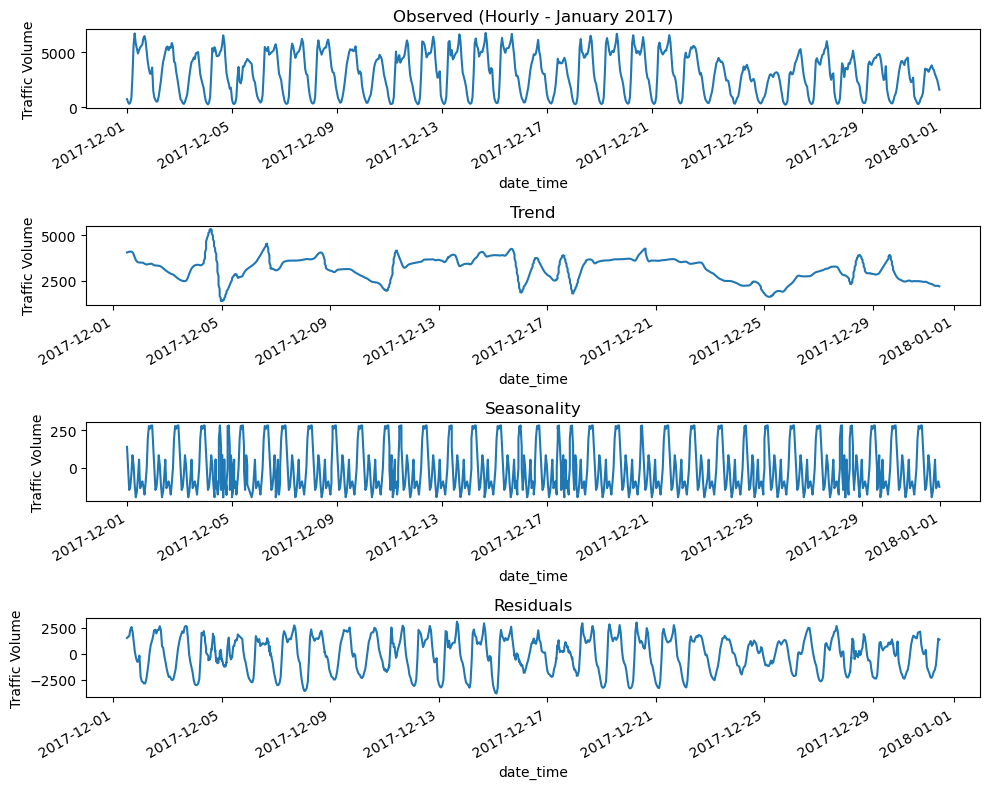

In [33]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
month_decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed (Hourly - January 2017)')
ax1.set_ylabel('Traffic Volume')

month_decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
ax2.set_ylabel('Traffic Volume')

month_decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonality')
ax3.set_ylabel('Traffic Volume')

month_decomposition.resid.plot(ax=ax4)
ax4.set_title('Residuals')
ax4.set_ylabel('Traffic Volume')

plt.tight_layout()
plt.savefig('hourly_decomposition.png')
plt.show()


### 2. TIME SERIES VISUALIZATION (at least 4 plots)


TIME SERIES VISUALIZATION



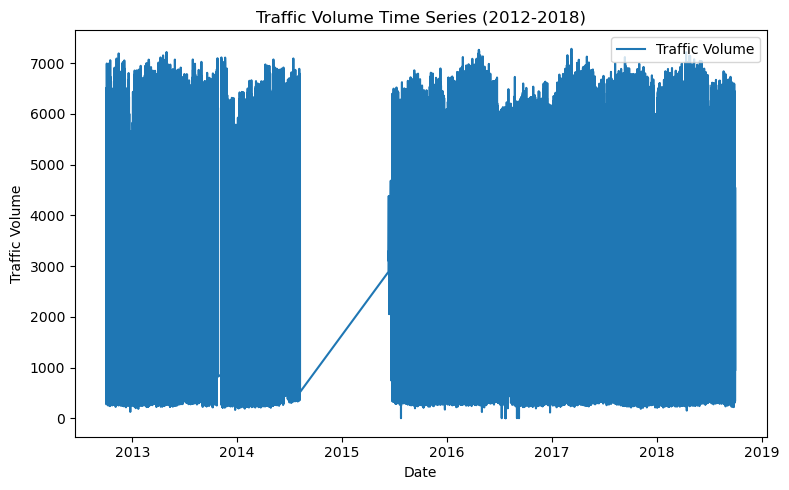

In [34]:
print("TIME SERIES VISUALIZATION\n")

plt.figure(figsize=(8, 5))
plt.plot(df['traffic_volume'], label='Traffic Volume')
plt.title('Traffic Volume Time Series (2012-2018)')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

Resampling to daily data for clearer visualization

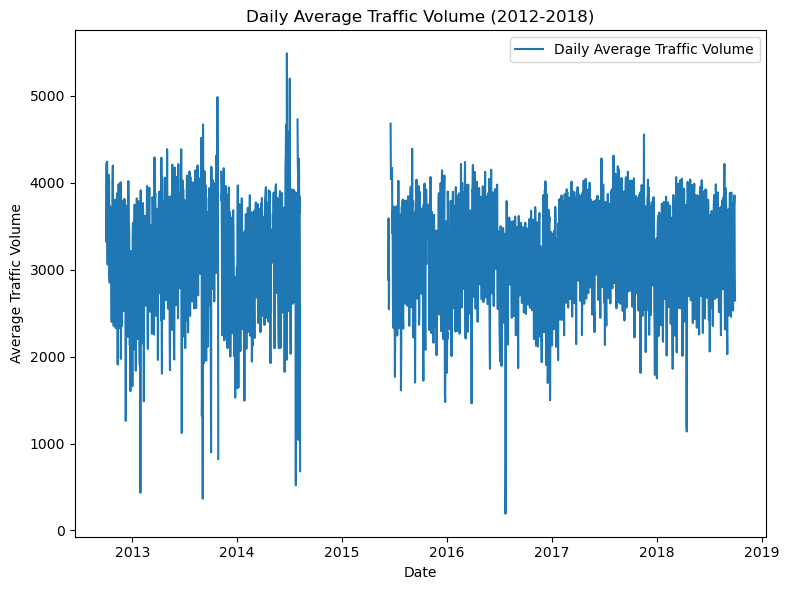

In [35]:
# Resampling to daily data for clearer visualization
daily_traffic = df['traffic_volume'].resample('D').mean()
plt.figure(figsize=(8, 6))
plt.plot(daily_traffic, label='Daily Average Traffic Volume')
plt.title('Daily Average Traffic Volume (2012-2018)')
plt.xlabel('Date')
plt.ylabel('Average Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

Monthly traffic pattern

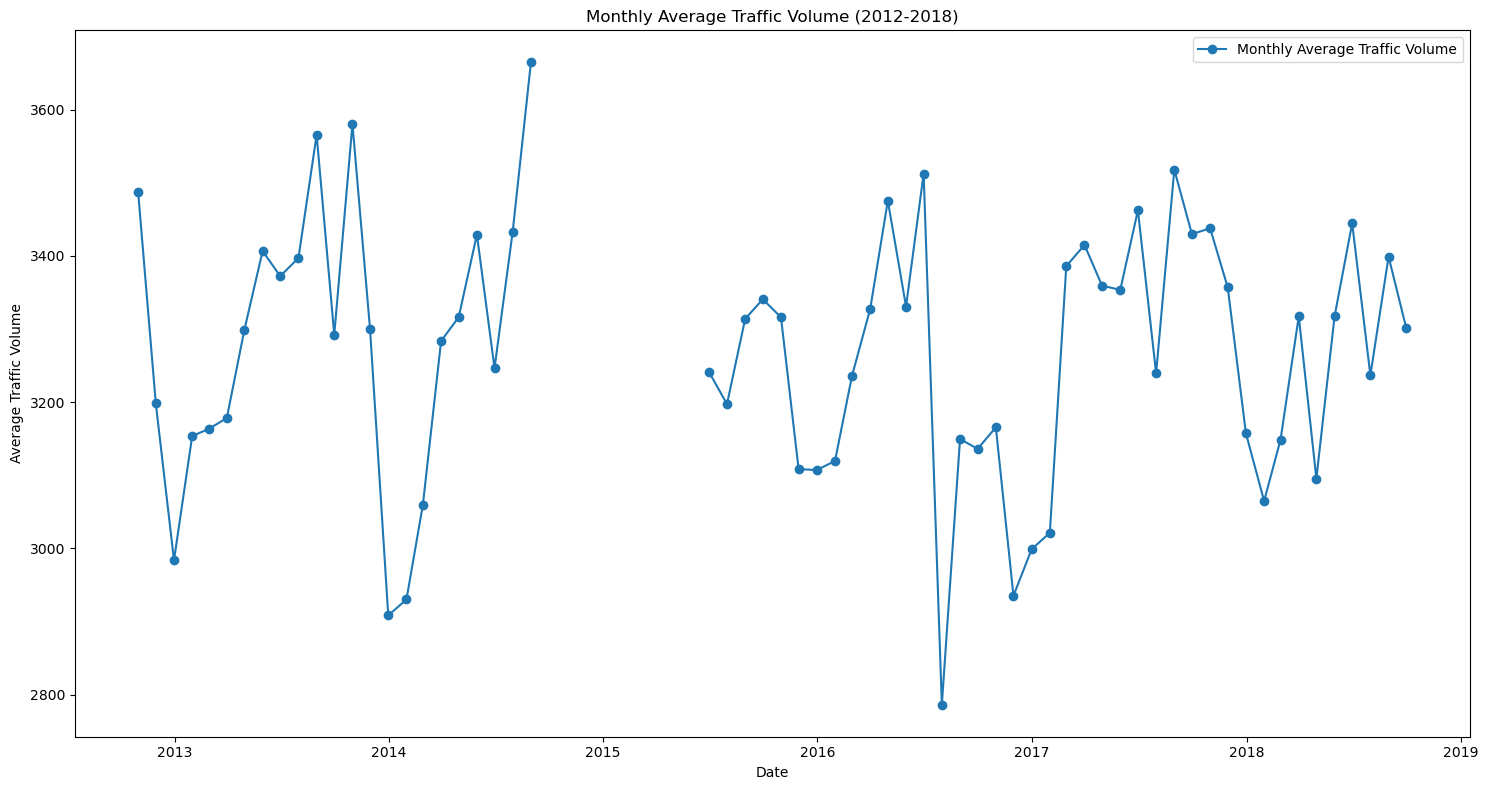

In [36]:
# Monthly traffic pattern
monthly_traffic = df['traffic_volume'].resample('M').mean()
plt.figure(figsize=(15, 8))
plt.plot(monthly_traffic, marker='o', linestyle='-', label='Monthly Average Traffic Volume')
plt.title('Monthly Average Traffic Volume (2012-2018)')
plt.xlabel('Date')
plt.ylabel('Average Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

Traffic volume by hour of day

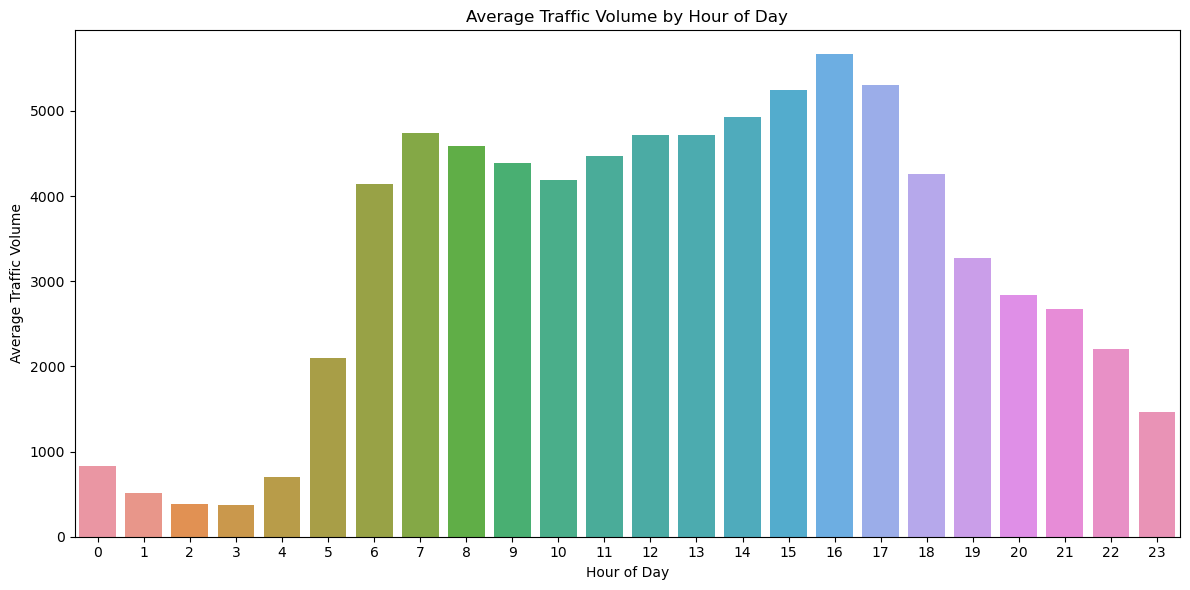

In [37]:
# Traffic volume by hour of day
hourly_traffic = df.groupby('hour')['traffic_volume'].mean()
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_traffic.index, y=hourly_traffic.values)
plt.title('Average Traffic Volume by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Traffic Volume')
plt.tight_layout()
plt.show()

3 pm-5 pm seems to have high traffic volume

Traffic volume by day of week

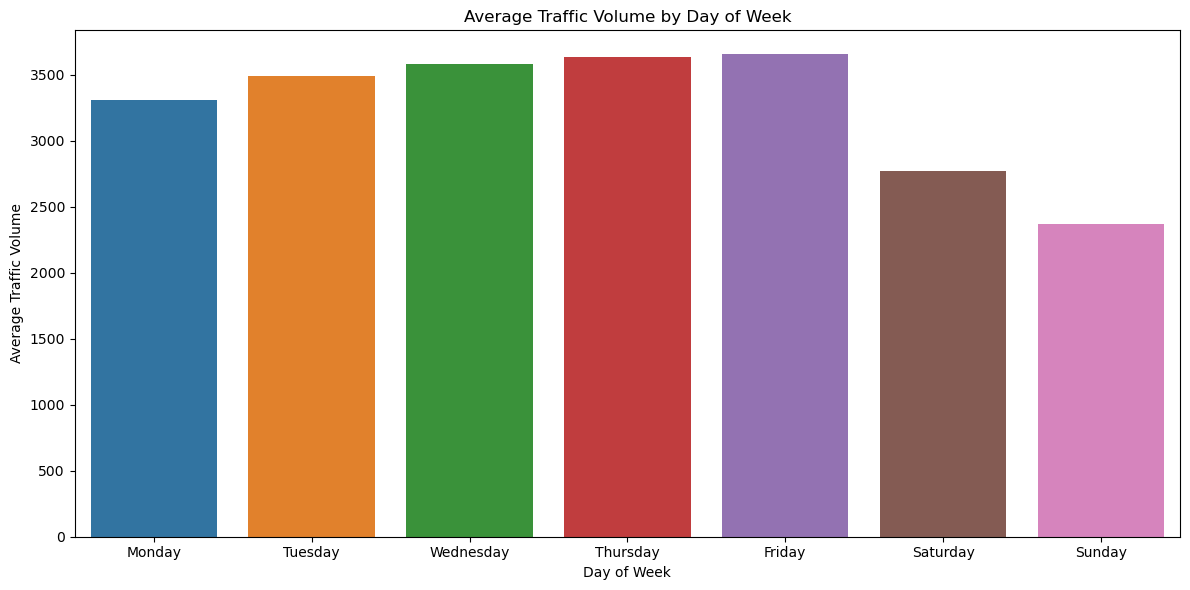

In [38]:
# Traffic volume by day of week
daily_pattern = df.groupby('day_of_week')['traffic_volume'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(12, 6))
sns.barplot(x=daily_pattern.index, y=daily_pattern.values)
plt.xticks(range(7), days)
plt.title('Average Traffic Volume by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Traffic Volume')
plt.tight_layout()
plt.show()

Thursday and Friday seems to have highest traffic volume, over all weekdays have more traffic volume compare to weekend.

Traffic volume variation with weather

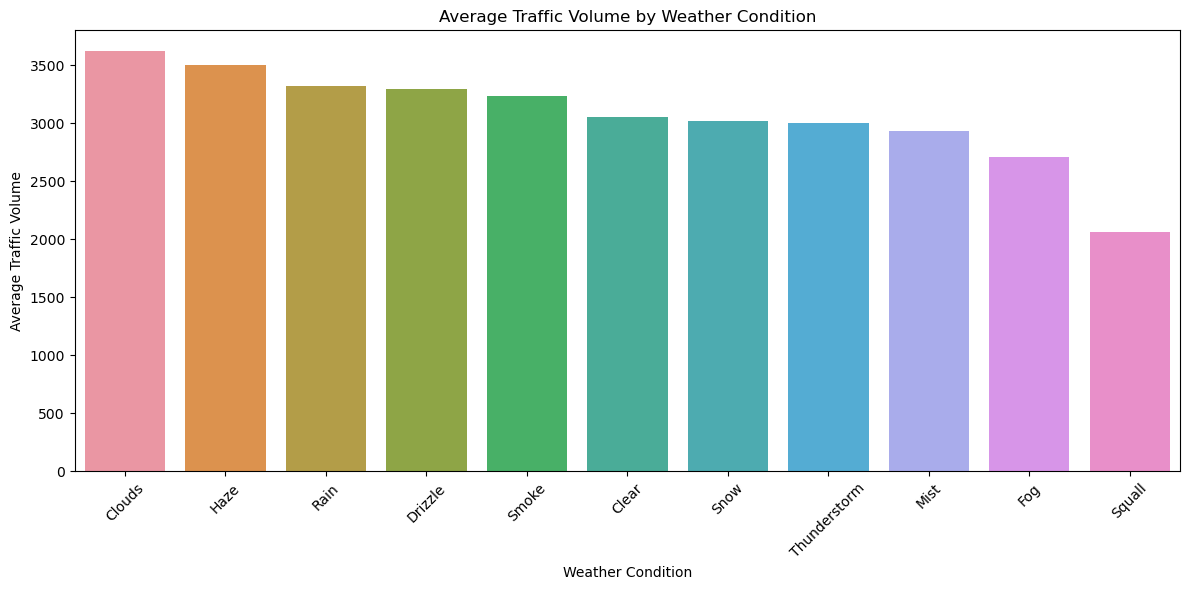

In [39]:
# Traffic volume variation with weather
weather_traffic = df.groupby('weather_main')['traffic_volume'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_traffic.index, y=weather_traffic.values)
plt.title('Average Traffic Volume by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Average Traffic Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Squall (definition from google - a sudden violent gust of wind or a localized storm, especially one bringing rain, snow, or sleet) has lowest traffic volume, which is expected in such harsh weather.

Correlation heatmap

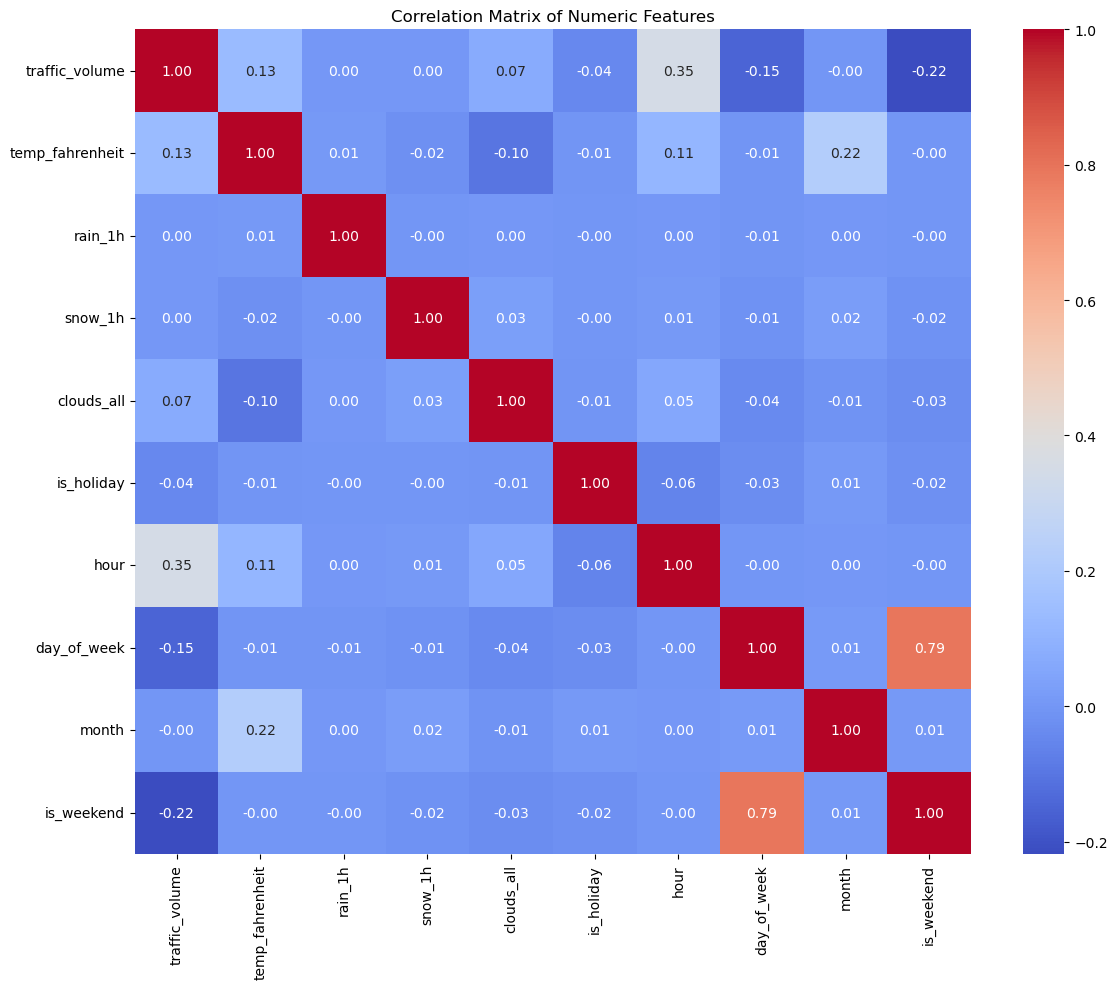

In [40]:
# Correlation heatmap
numeric_df = df[['traffic_volume', 'temp_fahrenheit', 'rain_1h', 'snow_1h', 'clouds_all', 'is_holiday', 'hour', 'day_of_week', 'month', 'is_weekend']]
plt.figure(figsize=(12, 10))
correlation = numeric_df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

Traffic volume has high correlation with hour of the day.

### 3. Description of Time series (is it stationary, are there any trends, seasonality etc)

Check stationarity using ADF test

In [41]:
# Check stationarity using ADF test
def check_stationarity(timeseries, window=12):
    
    # Rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # Plot rolling statistics
    plt.figure(figsize=(15, 8))
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label=f'Rolling Mean (window={window})')
    plt.plot(rolling_std, label=f'Rolling Std (window={window})')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.tight_layout()
    plt.show()
    
    # Perform ADF test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries.dropna())
    
    adf_output = {
        'Test Statistic': adf_test[0],
        'p-value': adf_test[1],
        'Lags Used': adf_test[2],
        'Number of Observations Used': adf_test[3],
        'Critical Values': adf_test[4]
    }
    
    for key, value in adf_output.items():
        if key == 'Critical Values':
            print(f'{key}:')
            for k, v in value.items():
                print(f'\t{k}: {v}')
        else:
            print(f'{key}: {value}')
    
    # Interpretation
    if adf_output['p-value'] <= 0.05:
        print("\nThe time series is stationary (reject H0 at 5% significance level)")
    else:
        print("\nThe time series is non-stationary (fail to reject H0 at 5% significance level)")


Check stationarity of daily resampled data

Stationarity Test for Daily Traffic Data:


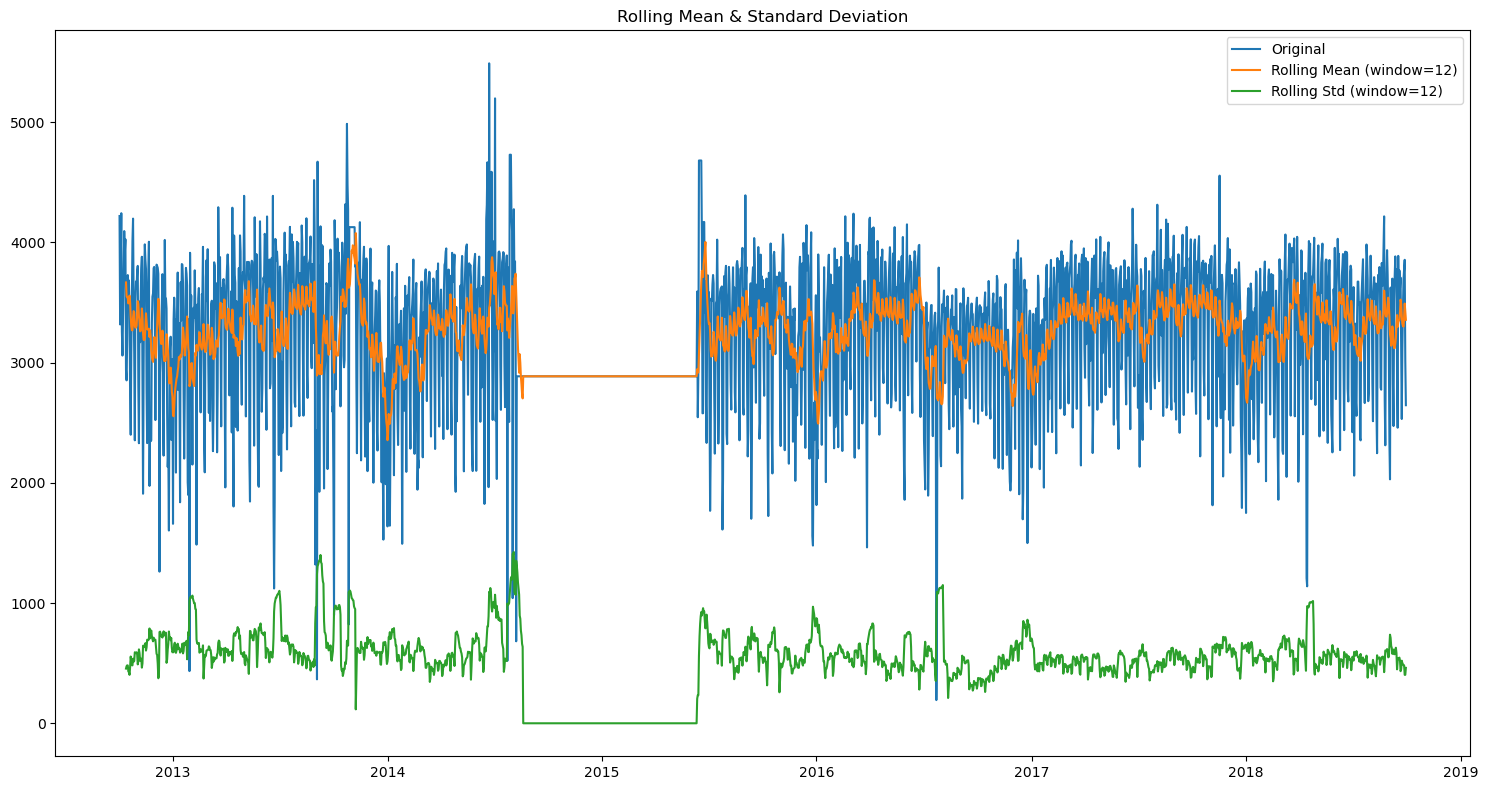

Results of Augmented Dickey-Fuller Test:
Test Statistic: -5.706475665603406
p-value: 7.468145160483132e-07
Lags Used: 26
Number of Observations Used: 2163
Critical Values:
	1%: -3.4333768504372877
	5%: -2.862877154888883
	10%: -2.5674818347939294

The time series is stationary (reject H0 at 5% significance level)


In [42]:
# Check stationarity of daily resampled data
print("Stationarity Test for Daily Traffic Data:")
check_stationarity(daily_data)

**Plot ACF and PACF to identify potential AR and MA terms**

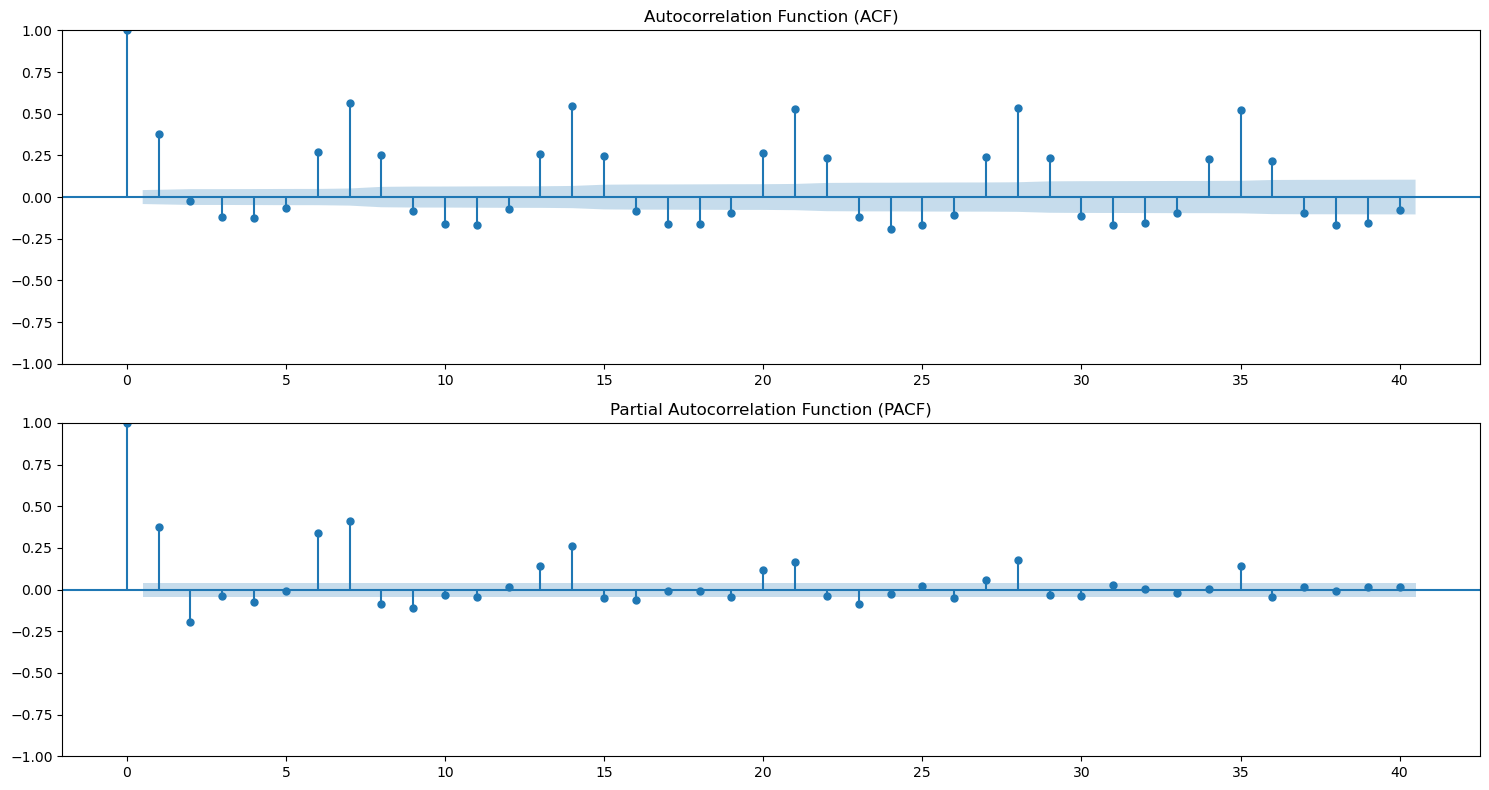

In [43]:
# Plot ACF and PACF to identify potential AR and MA terms
plt.figure(figsize=(15, 8))
plt.subplot(211)
plot_acf(daily_data.dropna(), lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(212)
plot_pacf(daily_data.dropna(), lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [44]:
diff_1 = daily_data.diff().dropna()

Plot ACF and PACF of differenced data

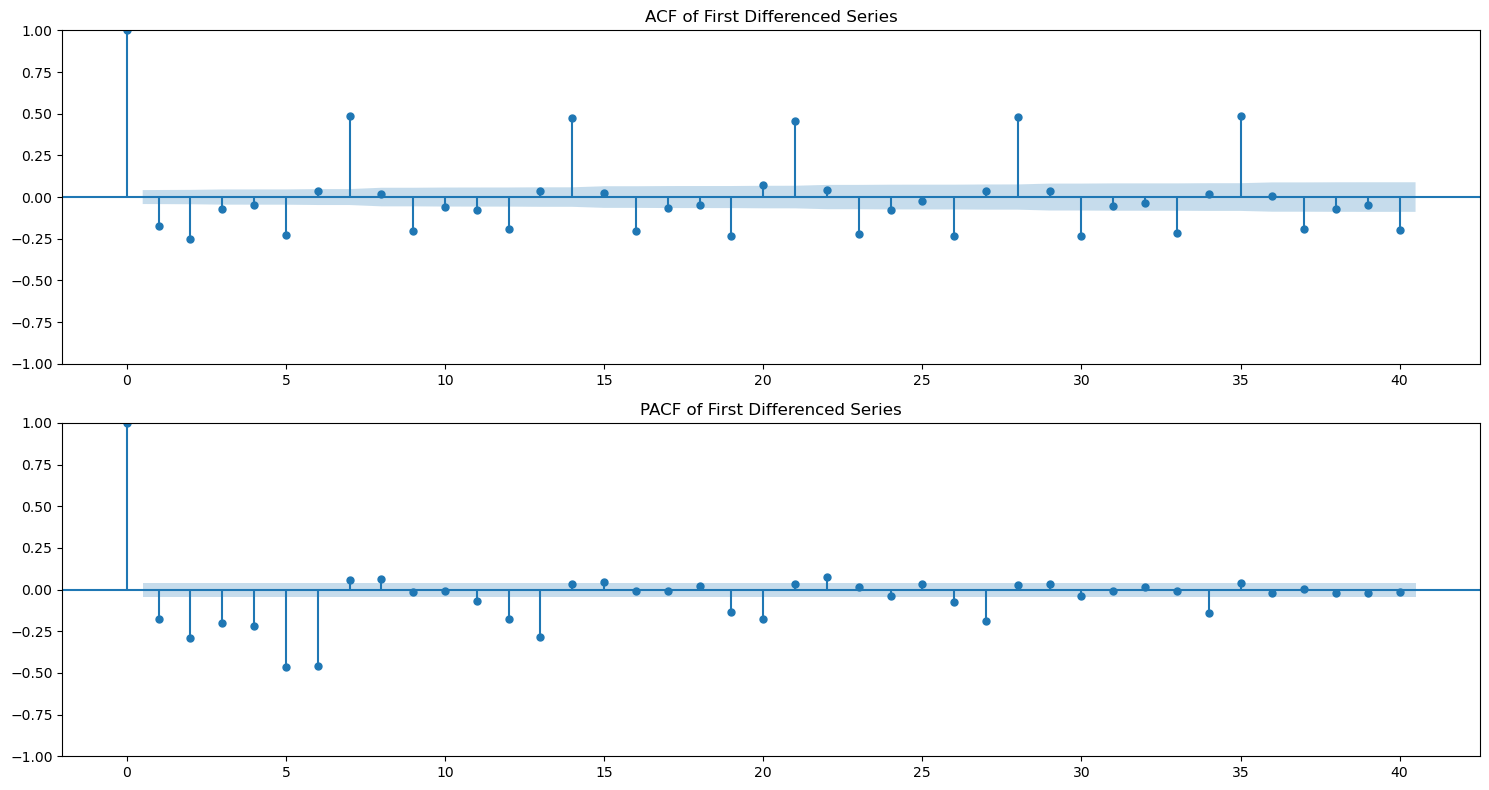

In [45]:
# Plot ACF and PACF of differenced data
plt.figure(figsize=(15, 8))
plt.subplot(211)
plot_acf(diff_1.dropna(), lags=40, ax=plt.gca())
plt.title('ACF of First Differenced Series')

plt.subplot(212)
plot_pacf(diff_1.dropna(), lags=40, ax=plt.gca())
plt.title('PACF of First Differenced Series')
plt.tight_layout()
plt.show()

### 4. TS models (transformations if needed). Make sure to explain your decision. Compare and select the best model. 

Prepare data for modeling

In [46]:
# Prepare data for modeling
# split data into training and testing
split_point = int(len(daily_data) * 0.8)
train_data = daily_data[:split_point]
test_data = daily_data[split_point:]

print(f"Training data: {train_data.index.min()} to {train_data.index.max()} ({len(train_data)} observations)")
print(f"Testing data: {test_data.index.min()} to {test_data.index.max()} ({len(test_data)} observations)")

Training data: 2012-10-02 00:00:00 to 2017-07-19 00:00:00 (1752 observations)
Testing data: 2017-07-20 00:00:00 to 2018-09-30 00:00:00 (438 observations)


#### ARIMA Model

Grid search to find optimal ARIMA parameters

In [47]:
# Grid search to find optimal ARIMA parameters
def arima_grid_search(data, p_range, d_range, q_range):
    best_aic = float('inf')
    best_order = None
    
    for p, d, q in itertools.product(p_range, d_range, q_range):
        try:
            model = ARIMA(data, order=(p, d, q))
            results = model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                
            print(f"ARIMA({p},{d},{q}) - AIC: {results.aic}")
            
        except Exception as e:
            continue
    
    print(f"\nBest ARIMA order: ARIMA{best_order} with AIC: {best_aic}")
    return best_order
print("Searching for optimal ARIMA parameters")
best_order = arima_grid_search(train_data, p_range=range(0, 3), d_range=range(0, 2), q_range=range(0, 3))

# Train the ARIMA model with the best parameters
arima_model = ARIMA(train_data, order=best_order)
arima_results = arima_model.fit()
print("\nARIMA Model Summary")
print(arima_results.summary())


Searching for optimal ARIMA parameters
ARIMA(0,0,0) - AIC: 27457.616679715647
ARIMA(0,0,1) - AIC: 27161.642726934282
ARIMA(0,0,2) - AIC: 27157.597450955636
ARIMA(0,1,0) - AIC: 27834.569942493676
ARIMA(0,1,1) - AIC: 27343.347296785956
ARIMA(0,1,2) - AIC: 27113.024040057386
ARIMA(1,0,0) - AIC: 27196.621313395935
ARIMA(1,0,1) - AIC: 27159.238985556454
ARIMA(1,0,2) - AIC: 27154.44469750887
ARIMA(1,1,0) - AIC: 27766.539065748744
ARIMA(1,1,1) - AIC: 27162.6166448422
ARIMA(1,1,2) - AIC: 27114.96557752257
ARIMA(2,0,0) - AIC: 27147.89390117205
ARIMA(2,0,1) - AIC: 27146.299430108975
ARIMA(2,0,2) - AIC: 26885.731051516537
ARIMA(2,1,0) - AIC: 27627.953777662653
ARIMA(2,1,1) - AIC: 27081.500804086834
ARIMA(2,1,2) - AIC: 27035.462578559825

Best ARIMA order: ARIMA(2, 0, 2) with AIC: 26885.731051516537

ARIMA Model Summary
                               SARIMAX Results                                
Dep. Variable:         traffic_volume   No. Observations:                 1752
Model:                

**Make predictions**

In [48]:
# Make predictions
arima_forecast = arima_results.forecast(steps=len(test_data))
arima_forecast = pd.Series(arima_forecast, index=test_data.index)

In [49]:
# Calculate error metrics
arima_mse = mean_squared_error(test_data, arima_forecast)
arima_rmse = np.sqrt(arima_mse)
arima_mae = mean_absolute_error(test_data, arima_forecast)
print(f"MSE: {arima_mse:.2f}")
print(f"RMSE: {arima_rmse:.2f}")
print(f"MAE: {arima_mae:.2f}")

MSE: 221238.26
RMSE: 470.36
MAE: 391.84


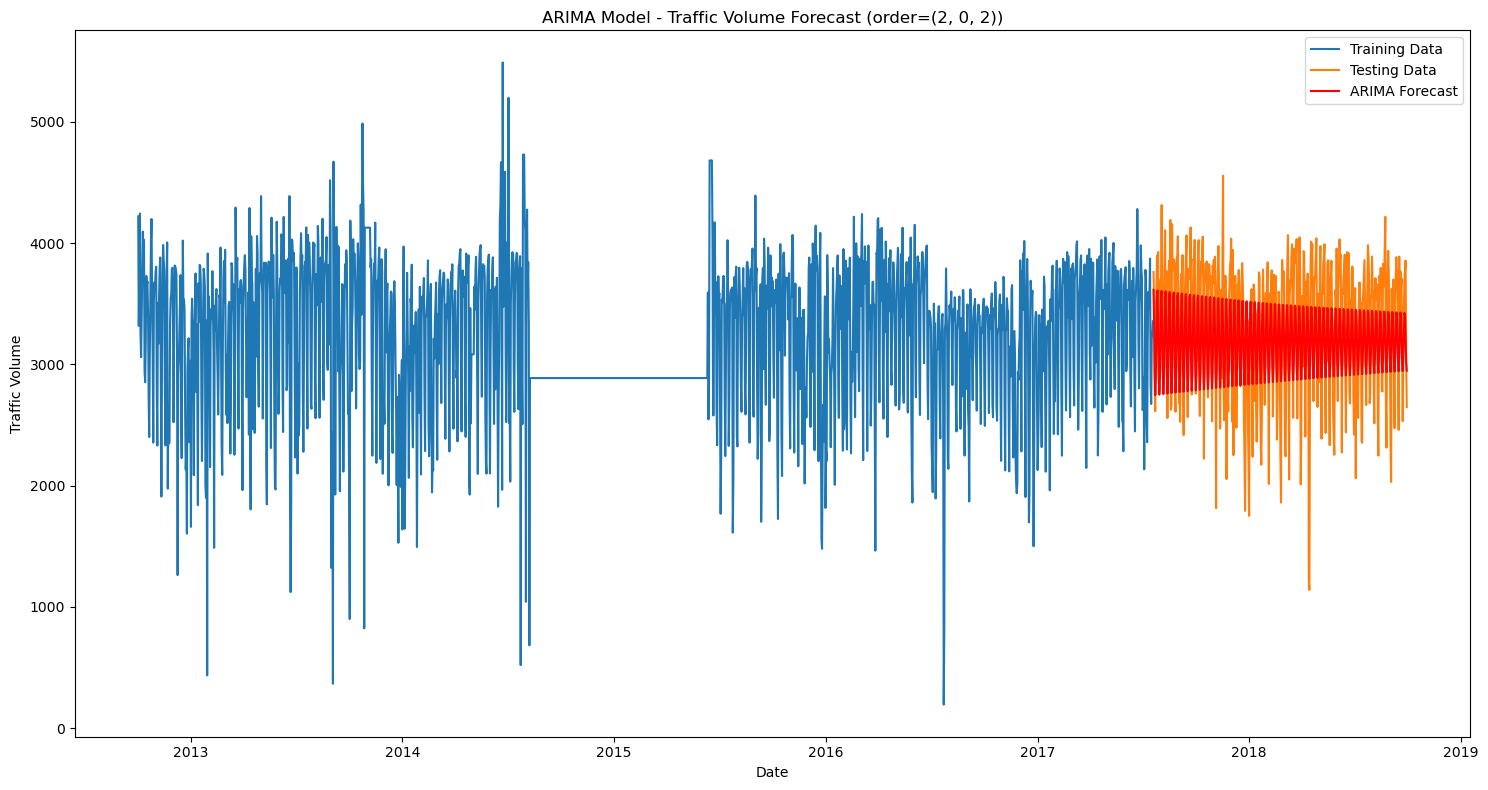

In [50]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.plot(test_data.index, arima_forecast, label='ARIMA Forecast', color='red')
plt.title(f'ARIMA Model - Traffic Volume Forecast (order={best_order})')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

#### SARIMA Model (Seasonal ARIMA)

In [51]:
# trying a SARIMA model with weekly seasonality (period=7)
sarima_model = SARIMAX(train_data, 
                      order=best_order,  
                      seasonal_order=(1, 1, 1, 7))  # Weekly seasonality
sarima_results = sarima_model.fit(disp=False)
print("SARIMA Model Summary")
print(sarima_results.summary())

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA Model Summary
                                      SARIMAX Results                                      
Dep. Variable:                      traffic_volume   No. Observations:                 1752
Model:             SARIMAX(2, 0, 2)x(1, 1, [1], 7)   Log Likelihood              -13066.537
Date:                             Tue, 08 Apr 2025   AIC                          26147.074
Time:                                     22:57:35   BIC                          26185.326
Sample:                                 10-02-2012   HQIC                         26161.216
                                      - 07-19-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6517      0.101     16.324      0.000       1.453       1.850
ar.L2 

**Make predictions**

In [52]:
# Make predictions
sarima_forecast = sarima_results.forecast(steps=len(test_data))
sarima_forecast = pd.Series(sarima_forecast, index=test_data.index)

In [53]:
# Calculate error metrics
sarima_mse = mean_squared_error(test_data, sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test_data, sarima_forecast)

print(f"MSE: {sarima_mse:.2f}")
print(f"RMSE: {sarima_rmse:.2f}")
print(f"MAE: {sarima_mae:.2f}")

MSE: 134638.16
RMSE: 366.93
MAE: 262.73


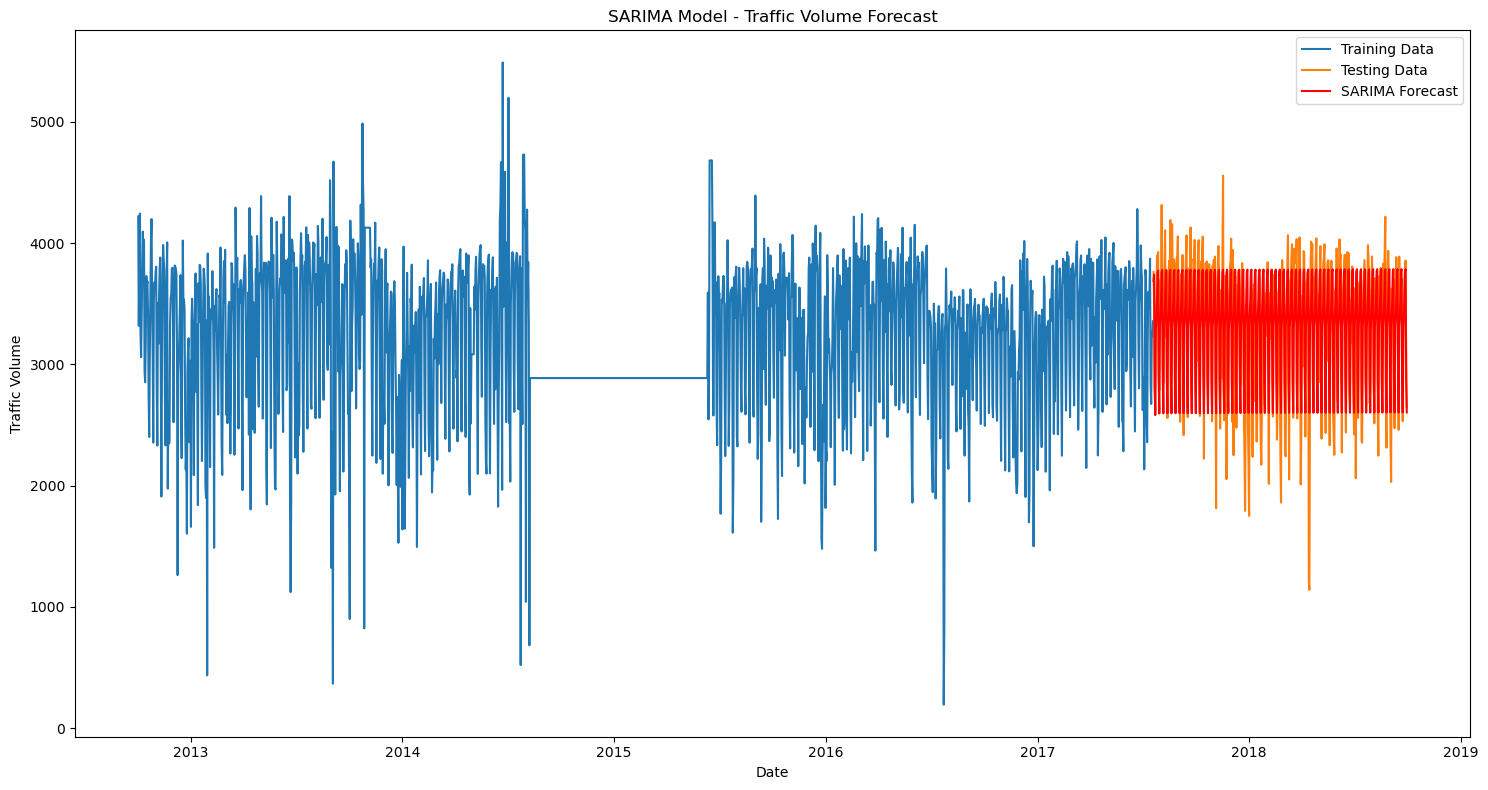

In [54]:
# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='red')
plt.title('SARIMA Model - Traffic Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

#### Prophet Model

In [56]:
#from prophet import Prophet

# Prepare data for Prophet
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data.values
})


In [57]:
# Train Prophet model
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_train)

22:58:55 - cmdstanpy - INFO - Chain [1] start processing
22:58:56 - cmdstanpy - INFO - Chain [1] done processing


In [58]:
# Create future dataframe for forecasting
prophet_future = pd.DataFrame({'ds': test_data.index})

# Generate forecast
prophet_forecast = prophet_model.predict(prophet_future)
print("\nProphet Forecast Components:")
print(prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


Prophet Forecast Components:
          ds         yhat   yhat_lower   yhat_upper
0 2017-07-20  3601.884474  2981.745578  4139.429216
1 2017-07-21  3613.800916  3006.595024  4211.403855
2 2017-07-22  2925.764410  2309.427911  3532.950499
3 2017-07-23  2613.203629  2032.541803  3174.941616
4 2017-07-24  3414.425292  2853.060064  3998.446434


In [59]:
# Calculate error metrics
prophet_mse = mean_squared_error(test_data.values, prophet_forecast['yhat'])
prophet_rmse = np.sqrt(prophet_mse)
prophet_mae = mean_absolute_error(test_data.values, prophet_forecast['yhat'])

print(f"MSE: {prophet_mse:.2f}")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAE: {prophet_mae:.2f}")

MSE: 127846.81
RMSE: 357.56
MAE: 256.95


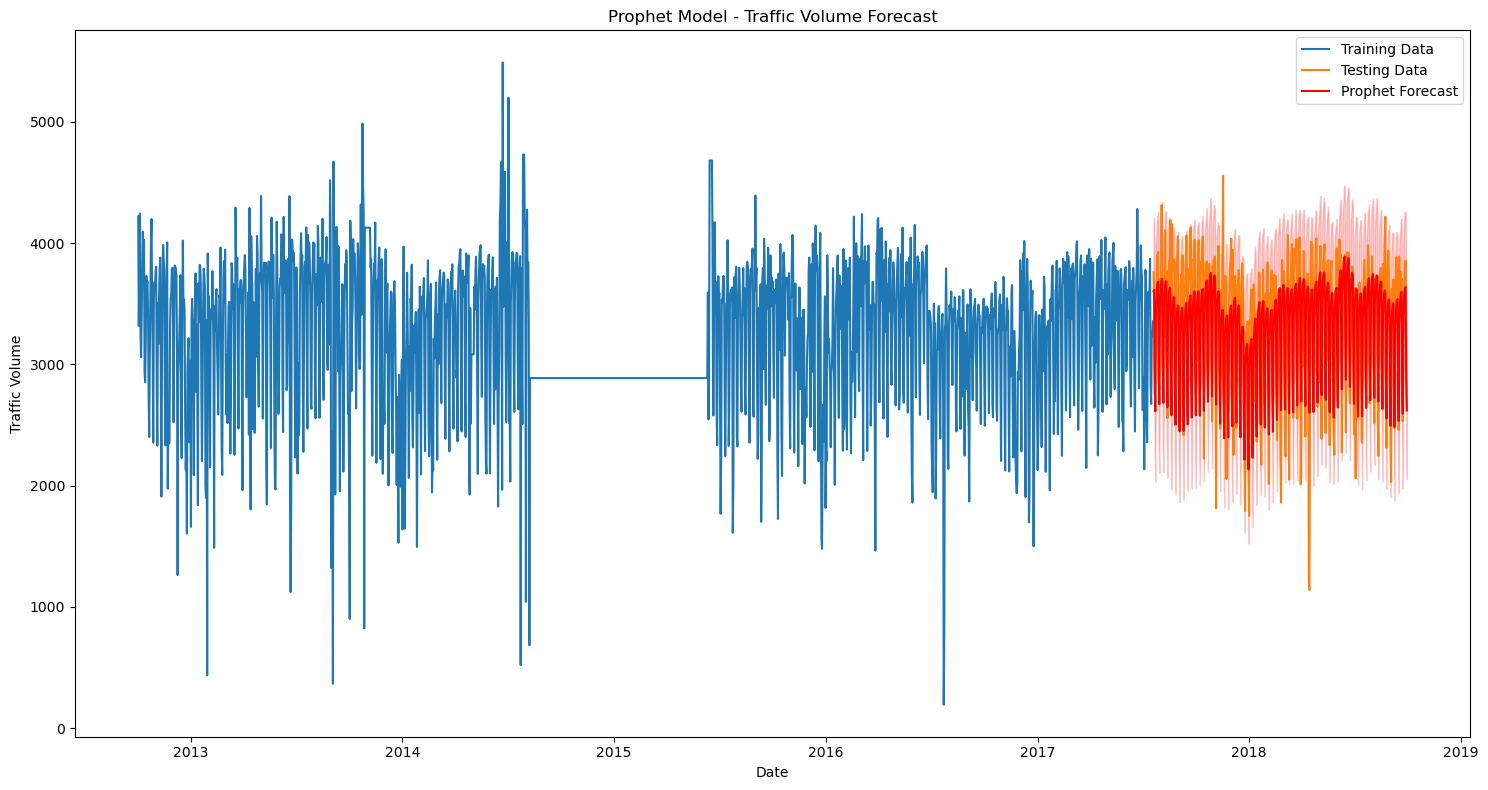

In [60]:
# Plot Prophet forecast
plt.figure(figsize=(15, 8))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, label='Testing Data')
plt.plot(prophet_forecast['ds'], prophet_forecast['yhat'], label='Prophet Forecast', color='red')
plt.fill_between(prophet_forecast['ds'], 
                 prophet_forecast['yhat_lower'], 
                 prophet_forecast['yhat_upper'], 
                 color='red', alpha=0.2)
plt.title('Prophet Model - Traffic Volume Forecast')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

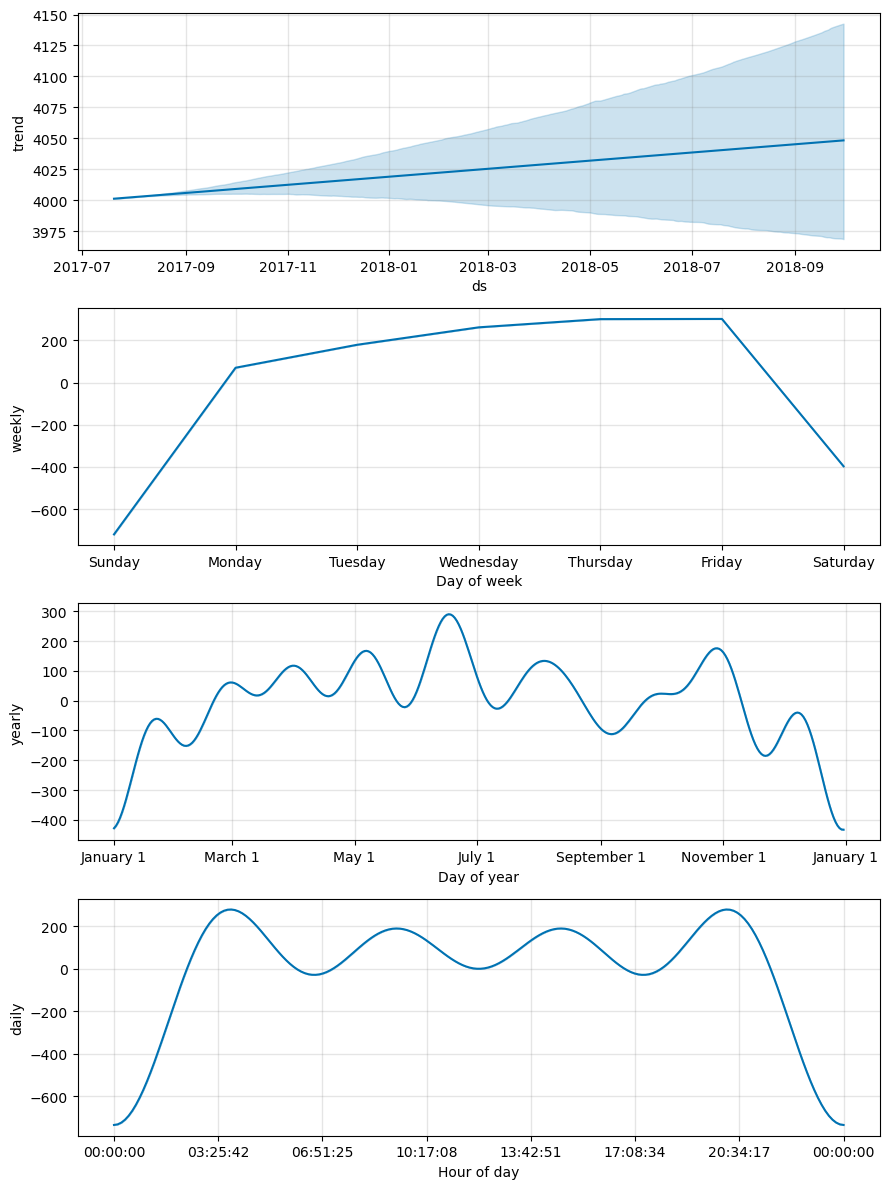

In [61]:
# Plot Prophet components
prophet_model.plot_components(prophet_forecast)
plt.tight_layout()
plt.show()

##### Compare all models

In [62]:
models = ['ARIMA', 'SARIMA', 'Prophet']
mse_values = [arima_mse, sarima_mse, prophet_mse]
rmse_values = [arima_rmse, sarima_rmse, prophet_rmse]
mae_values = [arima_mae, sarima_mae, prophet_mae]

comparison_df = pd.DataFrame({
    'Model': models,
    'MSE': mse_values,
    'RMSE': rmse_values,
    'MAE': mae_values
})
print(comparison_df)

     Model            MSE        RMSE         MAE
0    ARIMA  221238.264889  470.359719  391.839331
1   SARIMA  134638.162986  366.930733  262.729012
2  Prophet  127846.805205  357.556716  256.954564


Find the best model based on RMSE

In [63]:
best_model_index = comparison_df['RMSE'].idxmin()
best_model = comparison_df.loc[best_model_index, 'Model']
print(f"\nThe best model based on RMSE is: {best_model}")


The best model based on RMSE is: Prophet


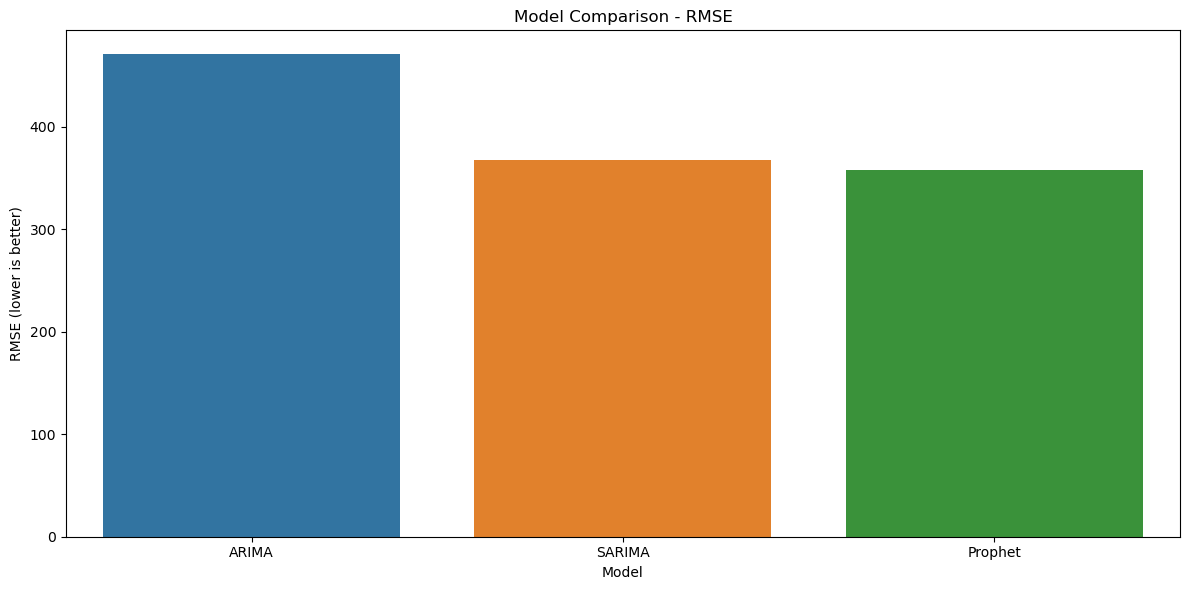

In [64]:
# Visualization of model comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=comparison_df)
plt.title('Model Comparison - RMSE')
plt.ylabel('RMSE (lower is better)')
plt.tight_layout()
plt.show()

I selected ARIMA because it works well for data with trends, and SARIMA is effective for seasonal data. The Prophet model was chosen for its strong performance in predicting traffic volume, as evidenced by its lower RMSE (357.56) compared to ARIMA and SARIMA. Prophet is specifically designed to handle time series data with seasonal patterns, holidays, and special events, which are key features in the traffic dataset. This model excels in handling missing data and outliers, which are common in traffic data, making it particularly suitable for this forecasting task. Additionally, its ability to incorporate external factors such as weather and holidays further enhances its predictive accuracy for forecasting future traffic conditions.

### 5. Predictions (make some predictions and plot them).

Use the best model to make future predictions

In [65]:
# For illustration, I'll use the Prophet model to forecast 30 days ahead
# First, create a combined dataset for fitting
all_data = pd.DataFrame({
    'ds': daily_data.index,
    'y': daily_data.values
})


In [66]:
# Train the Prophet model on all data
final_prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.05
)
final_prophet_model.fit(all_data)


23:00:39 - cmdstanpy - INFO - Chain [1] start processing
23:00:39 - cmdstanpy - INFO - Chain [1] done processing


In [67]:
# Create future dates for prediction (30 days ahead)
last_date = daily_data.index.max()
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
future_df = pd.DataFrame({'ds': future_dates})

# Generate the forecast
future_forecast = final_prophet_model.predict(future_df)

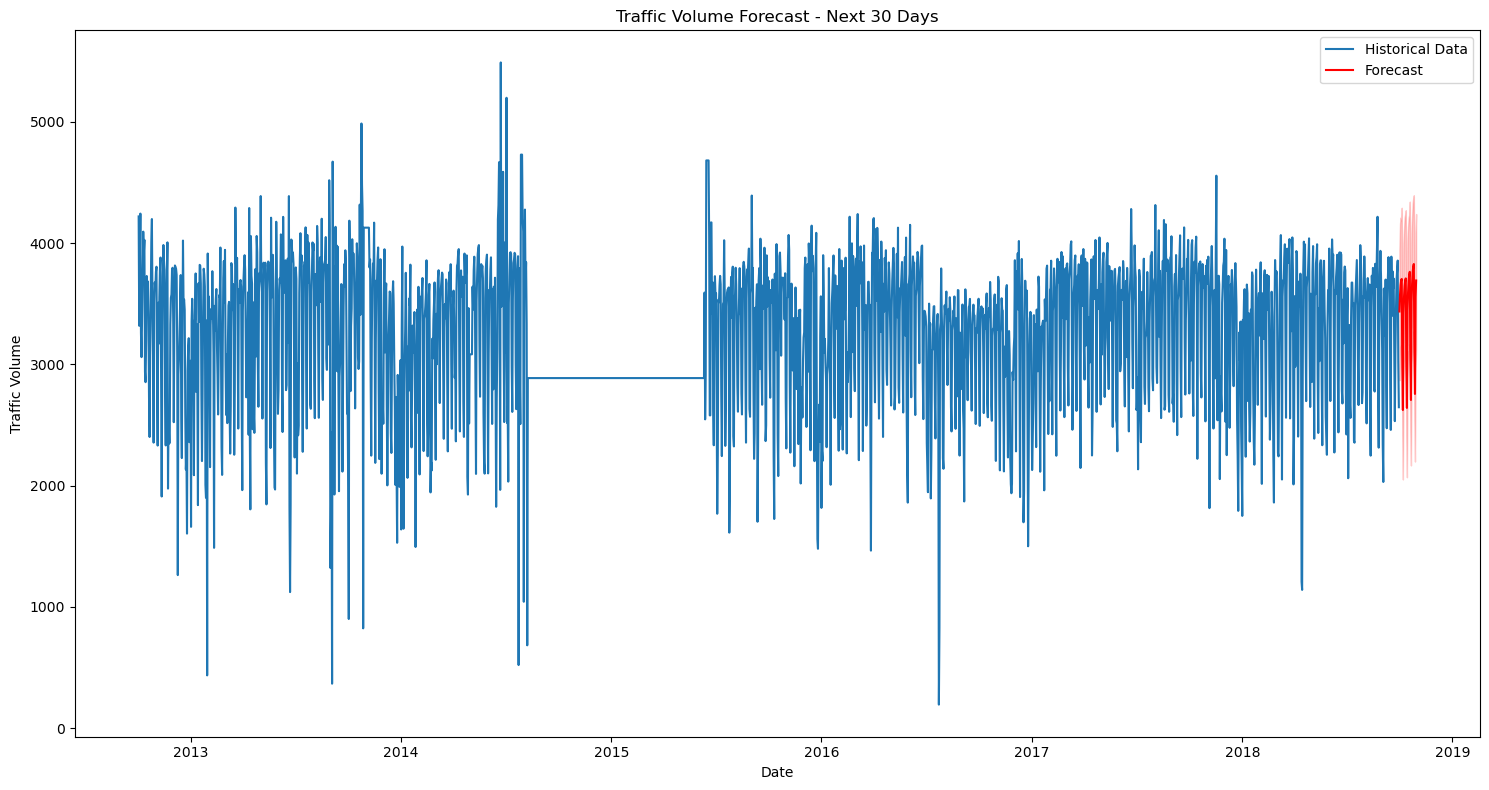

In [68]:
# Plot the forecast
plt.figure(figsize=(15, 8))
plt.plot(daily_data.index, daily_data, label='Historical Data')
plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Forecast', color='red')
plt.fill_between(future_forecast['ds'], 
                 future_forecast['yhat_lower'], 
                 future_forecast['yhat_upper'], 
                 color='red', alpha=0.2)
plt.title('Traffic Volume Forecast - Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.tight_layout()
plt.show()

Print the forecast values

**Note-** We have data from date 01-11-2012 to  08-31-2018 in the dataset

In [69]:
# Print the forecast values
print("\nForecast for the next 30 days:")
forecast_table = future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_table.columns = ['Date', 'Forecast', 'Lower Bound', 'Upper Bound']
forecast_table = forecast_table.set_index('Date')
print(forecast_table)


Forecast for the next 30 days:
               Forecast  Lower Bound  Upper Bound
Date                                             
2018-10-01  3435.200516  2868.082015  3949.858052
2018-10-02  3569.133197  3011.201918  4158.943981
2018-10-03  3652.567400  3128.674951  4210.957617
2018-10-04  3692.841076  3159.326474  4188.701512
2018-10-05  3703.964558  3129.508512  4290.656095
2018-10-06  2971.080410  2432.876908  3511.552412
2018-10-07  2622.579170  2049.903800  3182.032040
2018-10-08  3424.147697  2843.185367  3999.659467
2018-10-09  3559.948359  3010.185198  4111.397001
2018-10-10  3646.539893  3060.706159  4210.905154
2018-10-11  3691.179858  3149.984313  4236.976016
2018-10-12  3707.755177  3157.569360  4270.044267
2018-10-13  2981.244538  2410.006397  3538.998404
2018-10-14  2639.837960  2067.937110  3155.096691
2018-10-15  3448.990168  2888.607870  4024.772842
2018-10-16  3592.605889  3036.279943  4133.558845
2018-10-17  3686.967741  3108.972267  4208.681165
2018-10-18  3739.0

Plot a prediction for different days of the week

In [70]:
# Plot a prediction for different days of the week
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Get the first week of predictions
first_week = future_forecast.iloc[:7]
first_week['day_of_week'] = pd.to_datetime(first_week['ds']).dt.dayofweek
first_week['day_name'] = first_week['day_of_week'].apply(lambda x: days_of_week[x])



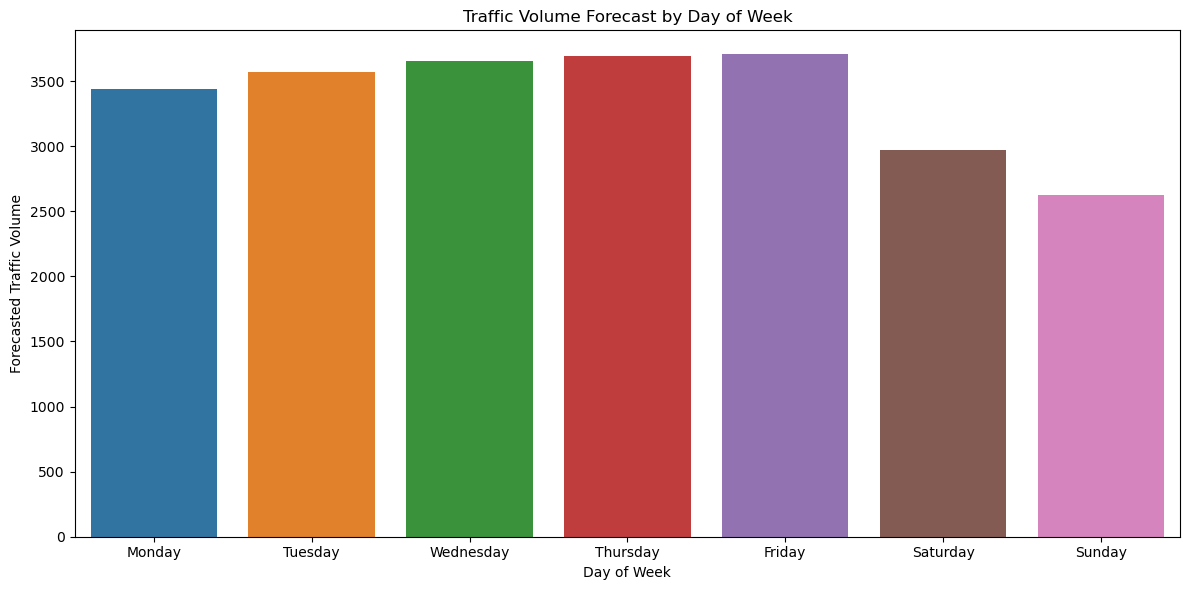

In [71]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_name', y='yhat', data=first_week)
plt.title('Traffic Volume Forecast by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Forecasted Traffic Volume')
plt.tight_layout()
plt.show()

Prediction seems to be accurate as we saw earlier that Wednesday-Friday, the traffic  volume is highest and Weekends are low.

### 6. Team contributions. For each team member, describe the contribution.

**Babita Kurmi** - Worked on Time series decomposition, TS Visualization, Description of time series, TS models, and Predictions

### 7. References

1. xreina8. (2023, July 31). Traffic volume prediction. Kaggle. https://www.kaggle.com/code/xreina8/traffic-volume-prediction
2. Tanwar, A. (2023, July 27). Interstate Traffic Dataset (US). Kaggle. https://www.kaggle.com/datasets/anshtanwar/metro-interstate-traffic-volume/data
3. YouTube. (n.d.). YouTube. https://www.youtube.com/watch?v=8lkXXOB94xQ  
4. Brownlee, J. (2020, August 25). Time series forecasting with Prophet in python. MachineLearningMastery.com. https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/ 